In [1]:
from datetime import datetime, timedelta
import pandas as pd

In [2]:
def get_day(date: datetime):
    base = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/"
    y, m, d = date.isoformat()[:10].split("-")
    return pd.read_csv(base + f"{m}-{d}-{y}.csv")

def get_data(df, exclude=None, include=None, **kwargs):
    states = ['Washington', 'New York', 'California', 'Massachusetts',
           'Diamond Princess', 'Grand Princess', 'Georgia', 'Colorado',
           'Florida', 'New Jersey', 'Oregon', 'Texas', 'Illinois',
           'Pennsylvania', 'Iowa', 'Maryland', 'North Carolina',
           'South Carolina', 'Tennessee', 'Virginia', 'Arizona', 'Indiana',
           'Kentucky', 'District of Columbia', 'Nevada', 'New Hampshire',
           'Minnesota', 'Nebraska', 'Ohio', 'Rhode Island', 'Wisconsin',
           'Connecticut', 'Hawaii', 'Oklahoma', 'Utah', 'Kansas', 'Louisiana',
           'Missouri', 'Vermont', 'Alaska', 'Arkansas', 'Delaware', 'Idaho',
           'Maine', 'Michigan', 'Mississippi', 'Montana', 'New Mexico',
           'North Dakota', 'South Dakota', 'West Virginia', 'Wyoming']
    if include:
        states = include
    if exclude:
        for e in exclude:
            states.remove(e)
    data = []
    for country in ["South Korea", "US", "Italy", "United Kingdom", "Norway"]:
        c_key = "Country/Region"
        s_key = "Province/State"
        if c_key not in df.columns:
            c_key = "Country_Region"
            s_key = "Province_State"
        idx = (df[c_key] == country)
        if country == "US":
            states = df[s_key].isin(states)
            if not states.sum():
                assert df.loc[idx, s_key].apply(lambda x: len(x.split(",")) == 2 or "Princess" in x).all()
            else:
                idx &= states
        if "Korea" in country:
            idx  |= df[c_key].isin(["Korea, South", "Republic of Korea"])
        if "United Kingdom" in country:
            idx  |= df[c_key].isin(["UK"])
        if country != "Norway":
            assert idx.sum()
        d = df[idx].set_index(s_key)
        data.append({
            "cases": d["Confirmed"].sum(),
            "deaths": d["Deaths"].sum(),
            "recovered": d["Recovered"].sum(),
            "country": country,
            **kwargs,
        })
    return data

In [3]:
df = get_day(datetime(2020, 2, 10))
df[df["Country/Region"] == "US"]

,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
55,"Chicago, IL",US,2020-02-09T19:03:03,2,0,2
56,"San Benito, CA",US,2020-02-03T03:53:02,2,0,0
57,"Santa Clara, CA",US,2020-02-03T00:43:02,2,0,0
66,"Boston, MA",US,2020-02-01T19:43:03,1,0,0
67,"Los Angeles, CA",US,2020-02-01T19:53:03,1,0,0
68,"Madison, WI",US,2020-02-05T21:53:02,1,0,0
69,"Orange, CA",US,2020-02-01T19:53:03,1,0,0
70,"Seattle, WA",US,2020-02-09T07:03:04,1,0,1
71,"Tempe, AZ",US,2020-02-01T19:43:03,1,0,0


In [4]:
# def get_date(x):
#     y = x[:10]
#     y, m, d = y.split("-")
#     return datetime(int(y), int(m), int(d))

# d = df[df["Country/Region"] == "US"].copy()
# d["datetime"] = d["Last Update"].apply(get_date)
# d.tail()

In [5]:
from urllib.request import HTTPError

dates = pd.date_range(datetime(2020, 2, 10), datetime.now())
data = []
for date in dates:
    try:
        datum = get_day(date)
    except HTTPError:
        print(date)
    else:
        data.extend(get_data(datum, date=date))

df = pd.DataFrame(data)

2020-03-28 00:00:00


In [6]:
df[df.country == "US"].tail()

,cases,deaths,recovered,country,date
211,43400,549,0,US,2020-03-23
216,53406,703,0,US,2020-03-24
221,65292,938,0,US,2020-03-25
226,83193,1205,0,US,2020-03-26
231,100921,1573,0,US,2020-03-27


cases                 int64
deaths                int64
recovered             int64
country              object
date         datetime64[ns]
dtype: object


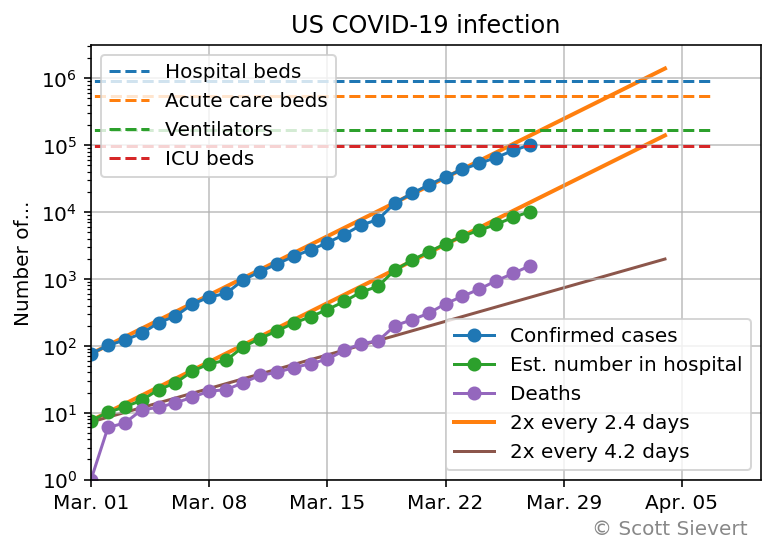

In [7]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
fig, ax = plt.subplots()
us = {
    "Hospital beds": 924100,
    "Acute care beds": 534964,
    "Ventilators": 168900,  # https://www.washingtonpost.com/health/2020/03/13/coronavirus-numbers-we-really-should-be-worried-about/
    "ICU beds": 96596,
    "hospitalization_rate": 0.1,  # https://twitter.com/LizSpecht/status/1236095180459003909
}  # https://www.sccm.org/Blog/March-2020/United-States-Resource-Availability-for-COVID-19

totals = {"south-korea": 0.9e4, "italy": 4e4}
c = "US"
show = df[df.country == c].copy()
print(show.dtypes)

line1, = ax.plot(show.date, show.cases, "C0o-", label="Confirmed cases")
line2, = ax.plot(show.date, show.cases * us["hospitalization_rate"], "C2o-", label="Est. number in hospital")
line3, = ax.plot(show.date, show.deaths, "C4o-", label="Deaths")

xlim = ax.get_xlim()
x = np.arange(50)
rate = 2.4
kwargs = {"linewidth": 2, "zorder": -1}
xticks = np.array([mdates.date2num(show.date.min() + timedelta(5, 12) + timedelta(int(d))) for d in x])
y = 2**(x / rate)
line4, = ax.plot(xticks, y, "C1", label=f"2x every {rate} days", **kwargs)
hosp  = us["hospitalization_rate"] * y
ax.plot(xticks, hosp, "C1", **kwargs)
drate = 4.2
y = 1.0 * 2**((x - 3) / drate)
line5, = ax.plot(xticks, y, "C5", label=f"2x every {drate} days", zorder=-1)

first_legend = ax.legend(loc="lower right", handles=[line1, line2, line3, line4, line5])
ax.add_artist(first_legend)

ax.set_title("US COVID-19 infection")
xlim = ax.get_xlim()

xlim = ax.get_xlim()
meta_lines = []
for label, num in us.items():
    if "_" in label:
        continue
    line, = ax.plot(xlim, [num, num], "--", label=label)
    meta_lines.append(line)
ax.legend(loc="upper left", handles=meta_lines)

ax.set_yscale("log")
ax.grid(alpha=0.8, which="major", axis="y")
# ax.grid(alpha=0.3, which="minor", axis="y")
ax.grid(alpha=0.8, which="both", axis="x")
new_xlim = [mdates.date2num(_) for _ in [datetime(2020, 3, 1)]]
ax.set_xlim(mdates.date2num(datetime(2020, 3, 1)), None)
ax.set_ylim(1, None)
ax.text(xlim[1] - 7, 0.15, "© Scott Sievert", color="#" + "8" * 6)
ax.set_ylabel("Number of...")
ax.set_xlabel("")

weeks = pd.date_range(start=df.date.min(), end=df.date.min() + timedelta(days=60), freq="1W")
weeks_mpl = [mdates.date2num(w) for w in weeks]
ax.xaxis.set_major_locator(plt.FixedLocator(weeks_mpl))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b. %d'))

# plt.savefig("us.svg", bbox_inches="tight")

In [8]:
from urllib.request import HTTPError

dates = pd.date_range(datetime(2020, 2, 10), datetime.now())
data = []
for date in dates:
    try:
        datum = get_day(date)
    except HTTPError:
        print(date)
    else:
        data.extend(get_data(datum, date=date, exclude=["New York"]))

df = pd.DataFrame(data)

2020-03-28 00:00:00


{'Hospital beds': 869539.4861896967, 'Acute care beds': 503378.7703603343, 'Ventilators': 158927.8424601664, 'ICU beds': 90892.79970563787, 'hospitalization_rate': 0.09409582146842299}
cases                 int64
deaths                int64
recovered             int64
country              object
date         datetime64[ns]
dtype: object


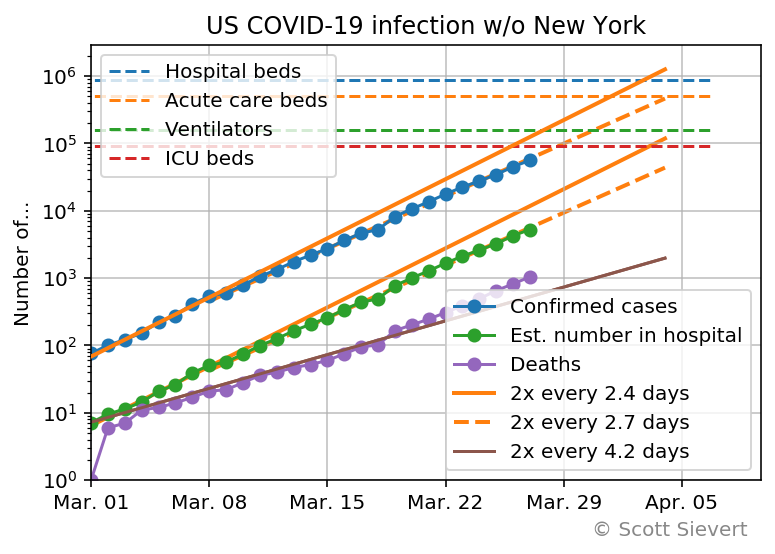

In [10]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
fig, ax = plt.subplots()
ny_pop = 19453561
us_pop = 329488021

us = {
    "Hospital beds": 924100,
    "Acute care beds": 534964,
    "Ventilators": 168900,  # https://www.washingtonpost.com/health/2020/03/13/coronavirus-numbers-we-really-should-be-worried-about/
    "ICU beds": 96596,
    "hospitalization_rate": 0.1,  # https://twitter.com/LizSpecht/status/1236095180459003909
}  # https://www.sccm.org/Blog/March-2020/United-States-Resource-Availability-for-COVID-19

for k, v in us.items():
    p_ny = ny_pop / us_pop
    us[k] = v * (1 - p_ny)
print(us)

totals = {"south-korea": 0.9e4, "italy": 4e4}
c = "US"
show = df[df.country == c].copy()
print(show.dtypes)

line1, = ax.plot(show.date, show.cases, "C0o-", label="Confirmed cases")
line2, = ax.plot(show.date, show.cases * us["hospitalization_rate"], "C2o-", label="Est. number in hospital")
line3, = ax.plot(show.date, show.deaths, "C4o-", label="Deaths")

xlim = ax.get_xlim()
x = np.arange(50)
rate = 2.4
kwargs = {"linewidth": 2, "zorder": -1}
xticks = np.array([mdates.date2num(show.date.min() + timedelta(5, 12) + timedelta(int(d))) for d in x])
rate = 2.7
y = 1.6 * 2 ** (x / rate)
y[y < 400] = np.nan
line4, = ax.plot(xticks, y, "C1--", label=f"2x every {rate} days", **kwargs)
hosp  = us["hospitalization_rate"] * y
ax.plot(xticks, hosp, "C1--", **kwargs)

rate = 2.4
y = 0.9 * 2 ** (x / rate)
kwds = kwargs.copy()
kwds.update({"zorder": 1000})
line4b, = ax.plot(xticks, y, "C1", label=f"2x every {rate} days", **kwds)
hosp  = us["hospitalization_rate"] * y
ax.plot(xticks, hosp, "C1", **kwargs)

drate = 4.2
y = 1 * 2**((x - 3) / drate)
line5, = ax.plot(xticks, y, "C5", label=f"2x every {drate} days", zorder=-1)

ax.plot(xticks, y, "C5")

first_legend = ax.legend(loc="lower right", handles=[line1, line2, line3, line4b, line4, line5])
ax.add_artist(first_legend)

ax.set_title("US COVID-19 infection w/o New York")
xlim = ax.get_xlim()

xlim = ax.get_xlim()
meta_lines = []
for label, num in us.items():
    if "_" in label:
        continue
    line, = ax.plot(xlim, [num, num], "--", label=label)
    meta_lines.append(line)
ax.legend(loc="upper left", handles=meta_lines)

ax.set_yscale("log")
ax.grid(alpha=0.8, which="major", axis="y")
# ax.grid(alpha=0.3, which="minor", axis="y")
ax.grid(alpha=0.8, which="both", axis="x")
new_xlim = [mdates.date2num(_) for _ in [datetime(2020, 3, 1)]]
ax.set_xlim(mdates.date2num(datetime(2020, 3, 1)), None)
ax.set_ylim(1, None)
ax.text(xlim[1] - 7, 0.15, "© Scott Sievert", color="#" + "8" * 6)
ax.set_ylabel("Number of...")
ax.set_xlabel("")

weeks = pd.date_range(start=df.date.min(), end=df.date.min() + timedelta(days=60), freq="1W")
weeks_mpl = [mdates.date2num(w) for w in weeks]
ax.xaxis.set_major_locator(plt.FixedLocator(weeks_mpl))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b. %d'))
# plt.savefig("us-wo-ny.svg", bbox_inches="tight")

In [11]:
meta = {
    "italy": {"population": 60317546, "beds_per_1000": 3.18},
    "us": {"population": 328239523, "beds_per_1000": 2.77},
    "south korea": {"population": 51709098, "beds_per_1000": 12.27},
    "germany": {"population": 83149300, "beds_per_1000": 8.00},
    "norway": {"population": 5367580, "beds_per_1000": 3.6},
    "singapore": {"population": 5638700, "beds_per_1000": None},
    "united kingdom": {"population": 67545757, "beds_per_1000": 2.54},
}
for k, v in meta.items():
    v["color"] = f"C{k}"

In [12]:
import numpy as np
df["conc"] = np.nan
for country in df.country.unique():
    idx = df.country == country
    df.loc[idx, "conc"] = df.loc[idx, "cases"] / meta[country.lower()]["population"]
    

In [13]:
def to_text(num, _):
    pwr = np.log10(num)
    rate = int(1 / num)
    if (rate + 1) % 10 == 0:
        rate += 1
    fmt = str(rate)
    if rate / 1000 > 1:
        fmt = f"{rate // 1000} thousand"
    if rate / 1000 == 1:
        fmt = f"a thousand"
    if rate / 1e6 > 1:
        fmt = f"{int(rate // 1e6)} million"
    if rate / 1e6 == 1:
        fmt = "a million"
    return "1 in {}".format(fmt)

53k hospital beds: https://www.dailywire.com/news/gov-cuomo-blasts-new-yorkers-not-taking-covid-19-seriously-its-insensitive-its-arrogant

In [14]:
# import pandas as pd
# times = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv")
# times.head()

# state = "New York"
# idx = (times["Province/State"] == state)
# ny = times[idx].drop(columns=["Province/State", "Country/Region", "Lat", "Long"]).T
# assert ny.shape[1] == 1
# ny = ny[ny.columns[0]]
# ny.index = pd.to_datetime(ny.index.values)
# ny = ny[ny > 0]

# import matplotlib.pyplot as plt
# fig, ax = plt.subplots()
# ax.plot(ny.index, ny.values, "o-", label=f"Confirmed cases in {state}")
# ax.set_yscale("log", basey=10)
# from datetime import datetime, timedelta
# import matplotlib.dates as mdates
# start = datetime(2020, 3, 10)
# ax.set_xlim(start, datetime(2020, 4, 1))
# ax.grid()
# import numpy as np
# _days = np.arange(40)
# days = [start + timedelta(int(d)) for d in _days]
# rate = 2.4
# cases = ny[ny > 0].min() * 2 ** (_days / rate)
# ax.plot(days, cases, label=f"$2\\times$ every {rate} days")
# xlim = ax.get_xlim()
# ylim = ax.get_ylim()
# ax.plot(xlim, [53e3, 53e3], "--")
# ax.set_ylim(ny.min().item() / 2, 2 * max(ny.max().item(), 55e3))
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%b. %d'))
# ax.legend(loc="best")


Text(737509.0, 2.5e-09, '© Scott Sievert')

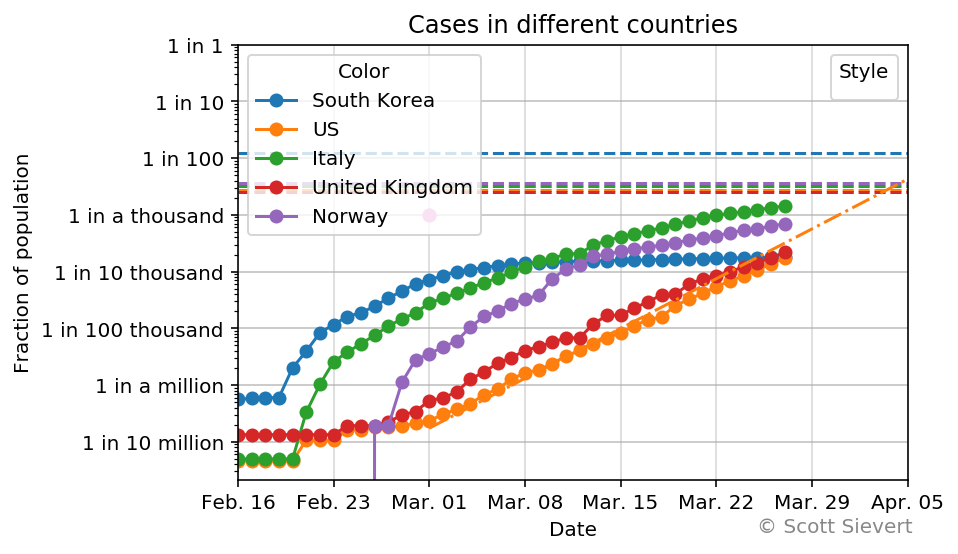

In [15]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots()
ax.set_xlim(mdates.date2num(datetime(2020, 2, 16)), datetime(2020, 4, 5))

lines = []
for k, c in enumerate(df.country.unique()):
    meta[c.lower()]["color"] = f"C{k}"
    show = df[df.country == c]
    line, = ax.plot(
        show["date"],
        show["conc"],
        "{}o-".format(meta[c.lower()]["color"]),
        label=c,
    )
    lines.append(line)

first_legend = ax.legend(handles=lines, loc="upper left", title="Color")
ax.add_artist(first_legend)

ax.set_yscale("log")
ax.set_ylim(None, 1)
ax.set_title("Cases in different countries")
ax.set_ylabel("Fraction of population")
ax.set_xlabel("Date")
ax.grid(alpha=0.8, which="major", axis="y")
ax.grid(alpha=0.5, which="major", axis="x")

weeks = pd.date_range(start=df.date.min(), end=df.date.max() + timedelta(days=40), freq="1W")
weeks_mpl = [mdates.date2num(w) for w in weeks]
ax.xaxis.set_major_locator(plt.FixedLocator(weeks_mpl))
ax.yaxis.set_major_locator(plt.LogLocator(numticks=20))

ax.yaxis.set_major_formatter(plt.FuncFormatter(to_text))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b. %d"))

xlim = ax.get_xlim()
for c in df.country.unique():
    beds = meta[c.lower()]["beds_per_1000"] / 1000
    ax.plot(xlim, [beds, beds], "--")

styles = {"-.": "Fit (2x every 2.4 days)", "o-": "Cases", "--": "Hospital beds"}
lines = []
for style, desc in styles.items():
    x = [mdates.date2num(datetime(2020, 3, 1)), mdates.date2num(datetime(2020, 3, 1))]
    line, = ax.plot(x, [1e-3, 1e-3], style, label=desc, alpha=1)
ax.legend(handles=lines, loc="upper right", title="Style")

# US predicted infections
days = np.arange(0, 50)

rate = 2.4
us_infections = 2 ** ((days - 0) / rate)
us_infections[us_infections < 50] = np.nan
us_conc = us_infections / meta["us"]["population"]

mdays = [mdates.date2num(datetime(2020, 2, 16) + timedelta(days=int(d))) for d in days]
ax.plot(mdays, us_conc, "{}-.".format(meta["us"]["color"]), label=f"US fit (2x every {rate} days)")
ax.text(mdates.date2num(datetime(2020, 3, 25)), 2.5e-9, "© Scott Sievert", color="#" + "8" * 6)


Custom legend implementation:

https://github.com/mwaskom/seaborn/blob/5498cdb2f145b15a85adac0c8ff233656f52a943/seaborn/relational.py#L589-L597

Calls `ax.get_legend_handles_labels()` https://github.com/mwaskom/seaborn/blob/5498cdb2f145b15a85adac0c8ff233656f52a943/seaborn/relational.py#L865, then calls `ax.legend()`

Text(0.5, 0, '')

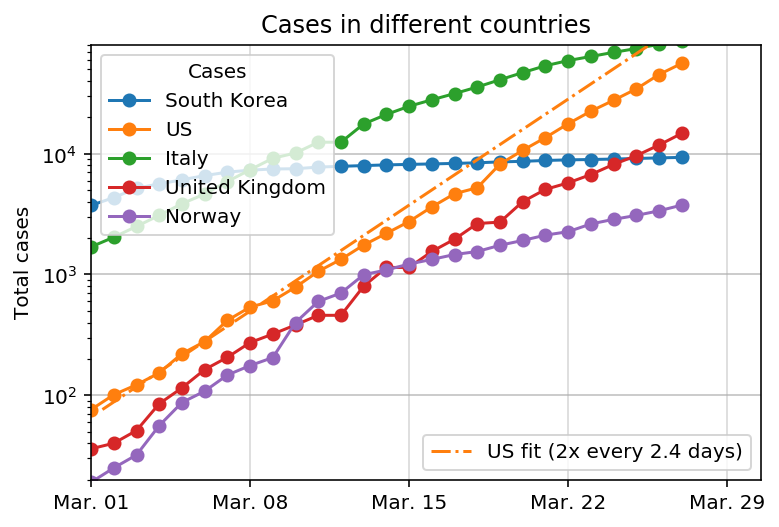

In [16]:
fig, ax = plt.subplots()
ax.set_xlim(mdates.date2num(datetime(2020, 3, 1)), datetime.now() + timedelta(2))

lines = []
for c in df.country.unique():
    show = df[df.country == c]
    line, = ax.plot(
        show["date"],
        show["cases"],
        "{}o-".format(meta[c.lower()]["color"]),
        label=c,
    )
    lines.append(line)
first_legend = ax.legend(handles=lines, loc="upper left", title="Cases")
ax.add_artist(first_legend)
ax.set_yscale("log")
ax.set_ylim(20, 8e4)
ax.set_title("Cases in different countries")
ax.set_ylabel("Total cases")
ax.set_xlabel("Date")
ax.grid(alpha=0.8, which="major", axis="y")
ax.grid(alpha=0.5, which="major", axis="x")

weeks = pd.date_range(start=df.date.min(), end=df.date.max() + timedelta(days=40), freq="1W")
weeks_mpl = [mdates.date2num(w) for w in weeks]
ax.xaxis.set_major_locator(plt.FixedLocator(weeks_mpl))
ax.yaxis.set_major_locator(plt.LogLocator(numticks=20))

ax.xaxis.set_major_formatter(mdates.DateFormatter("%b. %d"))

xlim = ax.get_xlim()

# US predicted infections
days = np.arange(0, 50)

rate = 2.4
us_infections = 2 ** ((days - 0) / rate)
us_infections[us_infections < 60] = np.nan
# us_conc = us_infections / meta["us"]["population"]

mdays = [mdates.date2num(datetime(2020, 2, 15, 12) + timedelta(days=int(d))) for d in days]
line,  = ax.plot(mdays, us_infections, "{}-.".format(meta["us"]["color"]), label=f"US fit (2x every {rate} days)")
ax.legend(loc="lower right", handles=[line])
ax.set_xlabel("")
# ax.text(mdates.date2num(datetime(2020, 3, 25)), 2.5e-9, "© Scott Sievert", color="#" + "8" * 6)


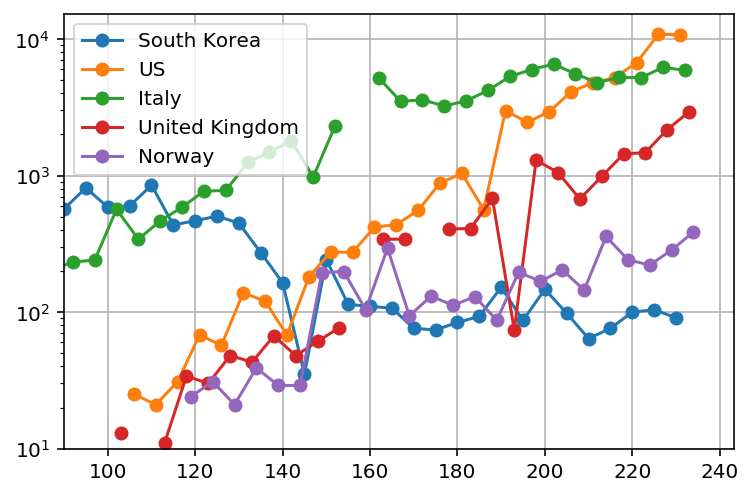

In [17]:
fig, ax = plt.subplots()
_min = 10
for c in df.country.unique():
    show = df[df.country == c]
    show = show.sort_values(by="date")
    y = show.cases.diff()
    y[y <= _min] = np.nan
    kwargs = {}
    if c == "United States":
        kwargs["zorder"] = 20
    ax.plot(y, "o-{}".format(meta[c.lower()]["color"]), label=c, **kwargs)
ax.set_yscale("log")
ax.set_ylim(_min, None)
ax.grid()
ax.set_xlim(90, None)
ax.legend(loc="best")


In [18]:
df.country.unique()

array(['South Korea', 'US', 'Italy', 'United Kingdom', 'Norway'],
      dtype=object)

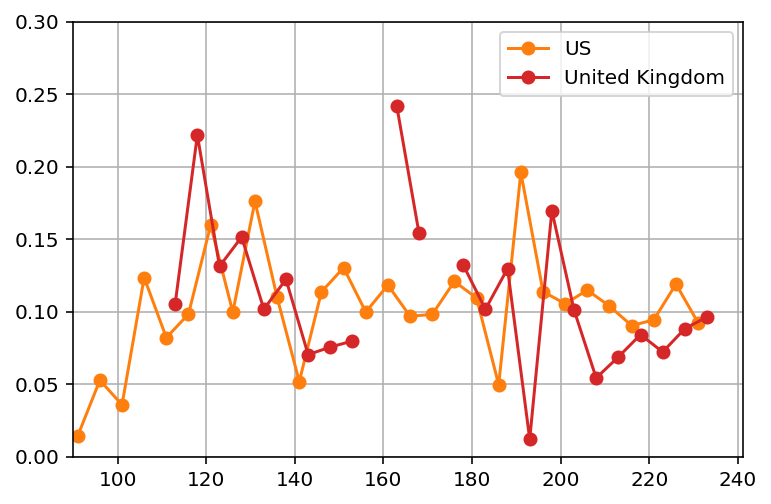

In [19]:
fig, ax = plt.subplots()
_min = 50
for c in df.country.unique():
#     if c in ["Norway", "United Kingdom"]:
#         continue
    if "United" not in c and "US" not in c:
        continue
    show = df[df.country == c]
    show = show.sort_values(by="date")
    y = np.log10(show.cases).diff()
    y[show.cases <= _min] = np.nan
    y[y <= 1e-3] = np.nan
    kwargs = {} if c not in ["us"] else {"linewidth": 3}
    ax.plot(y, "o-{}".format(meta[c.lower()]["color"]), label=c, **kwargs)
ax.set_ylim(0, .3)
ax.grid()
ax.set_xlim(90, None)
ax.legend(loc="best")


In [20]:
df[df.country == "Italy"].tail(n=11)

,cases,deaths,recovered,country,date,conc
182,31506,2503,2941,Italy,2020-03-17,0.000522
187,35713,2978,4025,Italy,2020-03-18,0.000592
192,41035,3405,4440,Italy,2020-03-19,0.000680
197,47021,4032,4440,Italy,2020-03-20,0.000780
202,53578,4825,6072,Italy,2020-03-21,0.000888
207,59138,5476,7024,Italy,2020-03-22,0.000980
212,63927,6077,7432,Italy,2020-03-23,0.001060
217,69176,6820,8326,Italy,2020-03-24,0.001147
222,74386,7503,9362,Italy,2020-03-25,0.001233
227,80589,8215,10361,Italy,2020-03-26,0.001336


In [21]:
show.dtypes

cases                 int64
deaths                int64
recovered             int64
country              object
date         datetime64[ns]
conc                float64
dtype: object

In [22]:
df.country.unique()

array(['South Korea', 'US', 'Italy', 'United Kingdom', 'Norway'],
      dtype=object)

In [23]:
def get_df(date):
    y, m, d = date.isoformat()[:10].split("-")
    assert len(y) == 4
    assert len(m) == 2
    assert len(d) == 2
    base = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/"
    url = base + f"{m}-{d}-{y}.csv"
    df = pd.read_csv(url)
    return df

def clean(df):
    s_key = "Province/State"
    if s_key not in df.columns:
        s_key = "Province_State"
    df["state"] = df[s_key]
    df["confirmed"] = df["Confirmed"]
    df["deaths"] = df["Deaths"]
    try:
        df["time"] = df["Last Update"]
    except KeyError:
        df["time"] = df["Last_Update"]
    return df[["state", "deaths", "confirmed", "time"]]

import pandas as pd
from datetime import datetime, timedelta
dates = pd.date_range(datetime(2020, 3, 10), datetime.now(), freq="1D")
rows = []
for date in dates[:-1]:
    df = get_df(date)
    c_key = "Country/Region"
    if c_key not in df.columns:
        c_key = "Country_Region"
    idx = df[c_key] == "US"
    df = df[idx]
    row = clean(df)
    rows.append(row)

In [24]:
df = pd.concat(rows)
df["datetime"] = pd.to_datetime(df["time"].str[:10])

In [25]:
df.columns

Index(['state', 'deaths', 'confirmed', 'time', 'datetime'], dtype='object')

In [26]:
import numpy as np

pops = pd.read_html("population.html")[0]
pops.set_index("State", inplace=True)
pops = pops["Population estimate, July 1, 2019[2]"]

df["rate"] = np.nan
for state in df.state.unique():
    idx = df.state == state
    if "princess" in state.lower():
        continue
    if "Virgin" in state:
        state = "U.S. Virgin Islands"
    if "US" in state:
        continue
    if state not in pops:
        continue
    df.loc[idx, "rate"] = df.loc[idx, "confirmed"] / pops[state]

In [27]:
df.columns

Index(['state', 'deaths', 'confirmed', 'time', 'datetime', 'rate'], dtype='object')

In [28]:
np.sort(df.state.unique())

array(['Alabama', 'Alaska', 'American Samoa', 'Arizona', 'Arkansas',
       'California', 'Colorado', 'Connecticut', 'Delaware',
       'Diamond Princess', 'District of Columbia', 'Florida', 'Georgia',
       'Grand Princess', 'Guam', 'Hawaii', 'Idaho', 'Illinois', 'Indiana',
       'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
       'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi',
       'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire',
       'New Jersey', 'New Mexico', 'New York', 'North Carolina',
       'North Dakota', 'Northern Mariana Islands', 'Ohio', 'Oklahoma',
       'Oregon', 'Pennsylvania', 'Puerto Rico', 'Recovered',
       'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee',
       'Texas', 'US', 'United States Virgin Islands', 'Utah', 'Vermont',
       'Virgin Islands', 'Virgin Islands, U.S.', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wuhan Evacuee', 'Wyoming'],
      dtype=object)

#####
Minnesota
            confirmed
datetime             
2020-03-23        234
2020-03-24        261
2020-03-25        286
2020-03-26        344
2020-03-27        396
#####
Wisconsin
            confirmed
datetime             
2020-03-23        425
2020-03-24        481
2020-03-25        621
2020-03-26        728
2020-03-27        926
#####
California
            confirmed
datetime             
2020-03-23       2108
2020-03-24       2538
2020-03-25       2998
2020-03-26       3899
2020-03-27       4657
#####
New York
            confirmed
datetime             
2020-03-23      20884
2020-03-24      25681
2020-03-25      30841
2020-03-26      37877
2020-03-27      44876
#####
Washington
            confirmed
datetime             
2020-03-23       2221
2020-03-24       2328
2020-03-25       2591
2020-03-26       3207
2020-03-27       3477


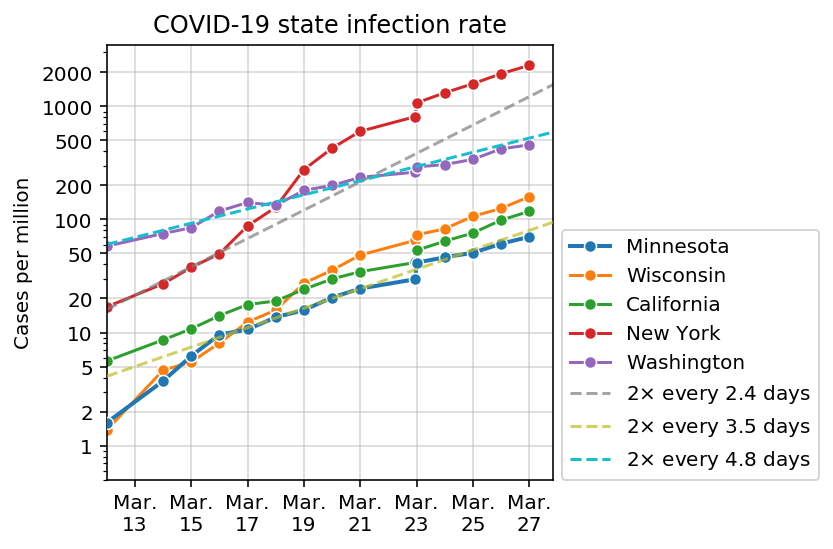

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters

states_to_show =  ["Minnesota", 
                   "Wisconsin",
                   "California", 
                   "New York", "Washington",  
                   ]
df["conc"] = df["rate"] * 1e6
w = 4
fig, ax = plt.subplots(figsize=(w, w))
for k, state in enumerate(states_to_show):
    kwds = {}
    if state in ["Minnesota"]:
        kwds = {"linewidth": 2, "zorder": 100}
    show = df[df.state == state]
    idx = (show.datetime == datetime(2020, 3, 16)) | (show.datetime == show.datetime.max())
    print("#" * 5)
    print(state)
    print(show.pivot_table(index="datetime", values="confirmed", aggfunc="sum").tail())
    sns.lineplot(
        x="datetime",
        y="conc",
        estimator="sum",
        ci=None,
        data=show,
        marker="o",
        label=state,
        color=f"C{k}",
        ax=ax,
        **kwds,
    )

ax.grid(alpha=0.5)
ax.set_yscale("log")

ax.set_xlim(mdates.date2num(datetime(2020, 3, 12)), None)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b.\n%d'))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: str(int(x))))
ax.yaxis.set_major_locator(plt.FixedLocator([1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10_000]))
ax.set_ylim(0.5, None)
# ax.set_xlim(None, datetime.now() + timedelta(5))
ax.set_ylabel("Cases per million")
ax.set_xlabel("Date")
ax.set_title("COVID-19 state infection rate")

_days = np.arange(50)
days = [datetime(2020, 3, 12) + timedelta(int(d)) for d in range(50)]
rate = 2.4
kwargs = {"alpha": 0.7}
ax.plot(days, 12 * 2 ** ((_days + 1) / rate), "C7--", label=f"2$\\times$ every {rate} days", **kwargs)
rate = 3.5
ax.plot(days, 5.0 * 2 ** ((_days-1) / rate), "C8--", label=f"2$\\times$ every {rate} days", zorder=100, **kwargs)
rate = 4.8
ax.plot(days, 52 * 2 ** ((_days + 1) / rate), "C9--", label=f"2$\\times$ every {rate} days")
ax.legend(loc=(1.02, 0))
ax.set_xlabel("")

# plt.savefig("us-states-hist.svg", bbox_inches="tight")

In [33]:
df[df.datetime == datetime(2020, 3, 13)]

,state,deaths,confirmed,time,datetime,rate,conc
142,Iowa,0,17,2020-03-13T23:53:03,2020-03-13,0.000005,5.388153
146,Kentucky,0,14,2020-03-13T23:53:03,2020-03-13,0.000003,3.133622
250,Alaska,0,1,2020-03-13T14:53:03,2020-03-13,0.000001,1.366970
264,Alaska,0,1,2020-03-13T14:53:03,2020-03-13,0.000001,1.366970


Text(0.5, 1.0, 'Infections per state')

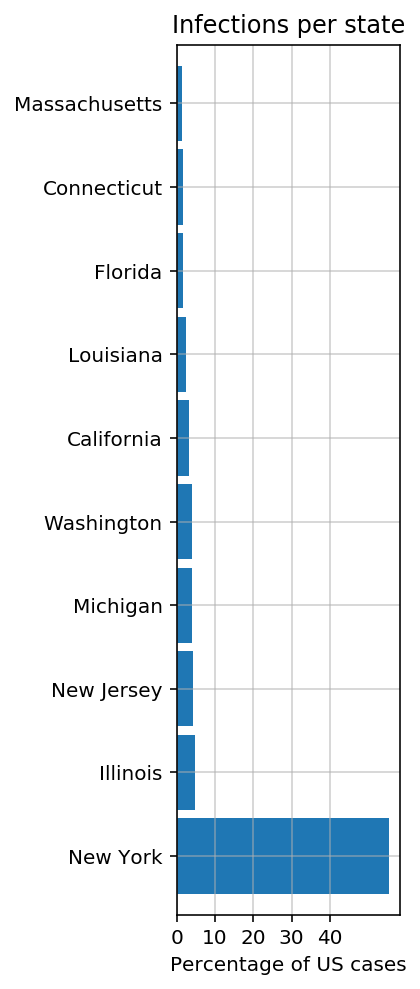

In [34]:
raw = {
    state: df[df.state == state].confirmed.max()
    for state in df.state.unique()
    if all(c not in state.lower() for c in ["puerto", "virgin", "princess", "guam"])
    and state.lower() != "us"
}
show = pd.Series(raw)
show /= show.sum()
show = 100 * show.sort_values(ascending=False)

w = 2
fig, ax = plt.subplots(figsize=(w, 4 * w))
ax = show.iloc[:10].plot.barh(zorder=0, xticks=[0, 10, 20, 30, 40], width=0.9)
ax.grid(alpha=0.6, zorder=-20)
ax.set_xlabel("Percentage of US cases")
ax.set_title("Infections per state")

# assert len(show) == 50
# df["percentage"] = df["confirmed"] / df["confirmed"].sum()
# # assert np.allclose(df["percentage"].sum(), 1)
# show = df.sort_values(by="percentage", ascending=False)
# show

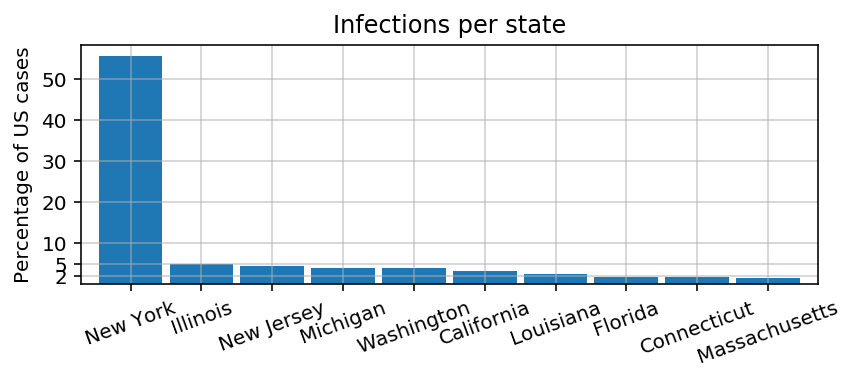

In [35]:
raw = {
    state: df[df.state == state].confirmed.max()
    for state in df.state.unique()
    if all(c not in state.lower() for c in ["puerto", "virgin", "princess", "guam"])
    and state.lower() != "us"
}
show = pd.Series(raw)
show /= show.sum()
show = 100 * show.sort_values(ascending=False)

w = 2.2
fig, ax = plt.subplots(figsize=(3 *w, w))
ax = show.iloc[:10].plot.bar(zorder=0, yticks=[2, 5, 10, 20, 30, 40, 50], width=0.9)
ax.grid(alpha=0.6, zorder=-20)
ax.set_ylabel("Percentage of US cases")
ax.set_title("Infections per state")
ax.set_xticklabels(ax.get_xticklabels(), rotation=20)
# plt.savefig("state-perc.svg", bbox_inches="tight")

[Text(0, 0, 'Washington'),
 Text(0, 0, 'Louisiana'),
 Text(0, 0, 'Georgia'),
 Text(0, 0, 'Michigan'),
 Text(0, 0, 'Connecticut'),
 Text(0, 0, 'California'),
 Text(0, 0, 'Texas'),
 Text(0, 0, 'New Jersey'),
 Text(0, 0, 'Florida'),
 Text(0, 0, 'New York'),
 Text(0, 0, 'Illinois'),
 Text(0, 0, 'Massachusetts'),
 Text(0, 0, 'Pennsylvania')]

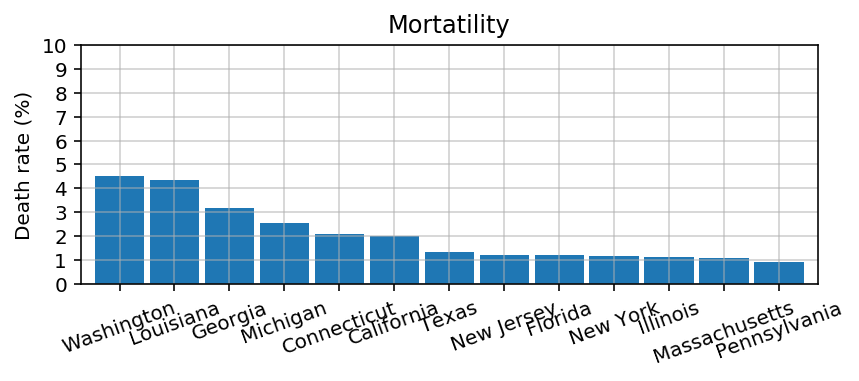

In [36]:
def _get_death_rate(df):
    d = df[df.datetime == df.datetime.max()]
    ret = d["deaths"].sum() / d["confirmed"].sum()
    return ret

good_states = {state for state in df.state.unique()
               if df.loc[df.state == state, "confirmed"].max() >= 500}
raw = {
    state: _get_death_rate(df[df.state == state])
    for state in good_states
    if all(c not in state.lower() for c in ["puerto", "virgin", "princess", "guam"])
    and state.lower() != "us"
}
show = pd.Series(raw)
show = 100 * show.sort_values(ascending=False)

w = 2.2
fig, ax = plt.subplots(figsize=(3 *w, w))
ax = show.iloc[:20].plot.bar(zorder=0, yticks=list(range(11)), width=0.9)
ax.grid(alpha=0.6, zorder=-20)
ax.set_ylabel("Death rate (%)")
ax.set_title("Mortatility")
ax.set_xticklabels(ax.get_xticklabels(), rotation=20)
# plt.savefig("state-perc.svg", bbox_inches="tight")